Introduction to the Dataset
The dataset contains information about credit risk with various features including demographic, financial, and loan-related attributes. The target variable is the CreditRiskClass, which indicates whether a customer has "Good" or "Bad" credit risk.

In [1]:
!pip install ucimlrepo

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

In [4]:
dataset_df = statlog_german_credit_data.data.original
COLUMN_RENAME_DICT = {
    'Attribute1': 'CheckingAccountStatus',
    'Attribute2': 'DurationInMonths',
    'Attribute3': 'CreditHistory',
    'Attribute4': 'Purpose',
    'Attribute5': 'CreditAmount',
    'Attribute6': 'SavingsAccountBonds',
    'Attribute7': 'EmploymentSince',
    'Attribute8': 'InstallmentRate',
    'Attribute9': 'PersonalStatusSex',
    'Attribute10': 'OtherDebtorsGuarantors',
    'Attribute11': 'ResidenceSince',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'OtherInstallmentPlans',
    'Attribute15': 'Housing',
    'Attribute16': 'ExistingCreditsCount',
    'Attribute17': 'Job',
    'Attribute18': 'PeopleLiableMaintenance',
    'Attribute19': 'Telephone',
    'Attribute20': 'ForeignWorker',
    'class': 'CreditRiskClass'
}

dataset_df = dataset_df.rename(columns = COLUMN_RENAME_DICT)
categorical_mappings = {
    'CheckingAccountStatus': {
        'A11': 'Less than 0 DM',
        'A12': '0 to 200 DM',
        'A13': '200 DM or more',
        'A14': 'No checking account'
    },
    'CreditHistory': {
        'A30': 'No credits taken', # individual has never taken out any credits
        'A31': 'All credits at this bank paid back duly', # individual has taken out credits from this particular bank and has paid them all back on time
        'A32': 'Existing credits paid back duly till now', # individual currently has existing credits and has been paying them back on time up to the present moment.
        'A33': 'Delay in paying off in the past', # individual has experienced delays in making credit payments in the past
        'A34': 'Critical account / other credits existing'
    },
    'Purpose': {
        'A40': 'Car (new)',
        'A41': 'Car (used)',
        'A42': 'Furniture/equipment',
        'A43': 'Radio/television',
        'A44': 'Domestic appliances',
        'A45': 'Repairs',
        'A46': 'Education',
        'A47': 'Vacation',
        'A48': 'Retraining',
        'A49': 'Business',
        'A410': 'Others'
    },
    'SavingsAccountBonds': {
        'A61': 'Less than 100 DM',
        'A62': '100 to 500 DM',
        'A63': '500 to 1000 DM',
        'A64': '1000 DM or more',
        'A65': 'Unknown / no savings account'
    },
    'EmploymentSince': {
        'A71': 'Unemployed',
        'A72': 'Less than 1 year',
        'A73': '1 to 4 years',
        'A74': '4 to 7 years',
        'A75': '7 years or more'
    },
    'PersonalStatusSex': {
        'A91': 'Male: divorced',
        'A92': 'Female: divorced/married',
        'A93': 'Male: single',
        'A94': 'Male: married/widowed',
        'A95': 'Female: single'
    },
    'OtherDebtorsGuarantors': {
        'A101': 'None',
        'A102': 'Co-applicant',
        'A103': 'Guarantor'
    },
    'Property': {
        'A121': 'Real estate',
        'A122': 'Building society savings agreement / life insurance',
        'A123': 'Car or other, not in attribute 6',
        'A124': 'Unknown / no property'
    },
    'OtherInstallmentPlans': {
        'A141': 'Bank',
        'A142': 'Stores',
        'A143': 'None'
    },
    'Housing': {
        'A151': 'Rent',
        'A152': 'Own',
        'A153': 'For free'
    },
    'Job': {
        'A171': 'Unemployed / unskilled - non-resident',
        'A172': 'Unskilled - resident',
        'A173': 'Skilled employee / official',
        'A174': 'Management / self-employed / \n highly qualified employee / officer'
    },
    'Telephone': {
        'A191': 'None',
        'A192': 'Yes, registered under the customer\'s name'
    },
    'ForeignWorker': {
        'A201': 'Yes',
        'A202': 'No'
    }
}
for column, mapping in categorical_mappings.items():
    dataset_df[column] = dataset_df[column].replace(mapping)

# Separating Personal Status from Gender in original feature "PersonalStatusSex"
dataset_df["Gender"] = dataset_df["PersonalStatusSex"].str.extract("([A-Za-z]+)")
dataset_df["PersonalStatus"] = dataset_df["PersonalStatusSex"].str.extract("(?<=:\s)(.*)$")
dataset_df = dataset_df.drop("PersonalStatusSex", axis=1)

# Replace values of the target variable, as defined in the instructions of the dataset
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].replace(1,0) # Good payer, low risk
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].replace(2,1) # Bad payer. high risk

credit_risk_class_map = ["Good", "Bad"]

dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].apply(lambda risk_class: credit_risk_class_map[risk_class])

Util

In [5]:
def create_frequency_table_with_credit_risk(index: str, df: pd.DataFrame):
    cross_table_credit_hist = pd.crosstab(df[index], df["CreditRiskClass"], margins=True)
    cross_table_credit_hist[f"P(Bad|{index})"] = cross_table_credit_hist["Bad"]/cross_table_credit_hist["All"]
    cross_table_credit_hist[f"P(Good|{index})"] = 1 - cross_table_credit_hist[f"P(Bad|{index})"]
    return cross_table_credit_hist

def detect_rare_categories(dataset_df: pd.DataFrame, threshold: int):
    categorical_cols = dataset_df.select_dtypes("object").columns

    for col_name in categorical_cols:
        rel_freq_s = dataset_df[col_name].value_counts(normalize=True)*100

        below_threshold = rel_freq_s[rel_freq_s < threshold].index.to_list()

        if (len(below_threshold)):
            print(f"\n Categories in Feature {col_name} below threshold freq: {below_threshold}")
            print("Relative Frequency: ")
            print(rel_freq_s)

def merge_categories(dataset_df: pd.DataFrame, feature: str, categories_to_merge: list, merged_category_name: str):
    dataset_df[feature] = dataset_df[feature].apply(lambda value: merged_category_name if value in categories_to_merge else value)
    return dataset_df

def detect_rare_ordinals(dataset_df: pd.DataFrame, threshold: int):
    numerical_cols = dataset_df.select_dtypes("int64")

    col_unique_counts_s = numerical_cols.nunique()

    ordinal_cols = col_unique_counts_s[col_unique_counts_s < 8].index

    for col_name in ordinal_cols:
        rel_freq_s = dataset_df[col_name].value_counts(normalize=True)*100

        below_threshold = rel_freq_s[rel_freq_s < threshold].index.to_list()

        if (len(below_threshold)):
            print(f"\n Categories in Feature {col_name} below threshold freq: {below_threshold}")
            print("Relative Frequency: ")
            print(rel_freq_s)

Summary Statistics


Overview of the Dataset

In [6]:
# Display the first few rows of the dataset
dataset_df.head()


,CheckingAccountStatus,DurationInMonths,CreditHistory,Purpose,CreditAmount,SavingsAccountBonds,EmploymentSince,InstallmentRate,OtherDebtorsGuarantors,ResidenceSince,...,OtherInstallmentPlans,Housing,ExistingCreditsCount,Job,PeopleLiableMaintenance,Telephone,ForeignWorker,CreditRiskClass,Gender,PersonalStatus
0,Less than 0 DM,6,Critical account / other credits existing,Radio/television,1169,Unknown / no savings account,7 years or more,4,None,4,...,None,Own,2,Skilled employee / official,1,"Yes, registered under the customer's name",Yes,Good,Male,single
1,0 to 200 DM,48,Existing credits paid back duly till now,Radio/television,5951,Less than 100 DM,1 to 4 years,2,None,2,...,None,Own,1,Skilled employee / official,1,None,Yes,Bad,Female,divorced/married
2,No checking account,12,Critical account / other credits existing,Education,2096,Less than 100 DM,4 to 7 years,2,None,3,...,None,Own,1,Unskilled - resident,2,None,Yes,Good,Male,single
3,Less than 0 DM,42,Existing credits paid back duly till now,Furniture/equipment,7882,Less than 100 DM,4 to 7 years,2,Guarantor,4,...,None,For free,1,Skilled employee / official,2,None,Yes,Good,Male,single
4,Less than 0 DM,24,Delay in paying off in the past,Car (new),4870,Less than 100 DM,1 to 4 years,3,None,4,...,None,For free,2,Skilled employee / official,2,None,Yes,Bad,Male,single


In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CheckingAccountStatus    1000 non-null   object
 1   DurationInMonths         1000 non-null   int64 
 2   CreditHistory            1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   CreditAmount             1000 non-null   int64 
 5   SavingsAccountBonds      1000 non-null   object
 6   EmploymentSince          1000 non-null   object
 7   InstallmentRate          1000 non-null   int64 
 8   OtherDebtorsGuarantors   1000 non-null   object
 9   ResidenceSince           1000 non-null   int64 
 10  Property                 1000 non-null   object
 11  Age                      1000 non-null   int64 
 12  OtherInstallmentPlans    1000 non-null   object
 13  Housing                  1000 non-null   object
 14  ExistingCreditsCount     1000 non-null   

In [8]:
dataset_df.columns

Index(['CheckingAccountStatus', 'DurationInMonths', 'CreditHistory', 'Purpose',
       'CreditAmount', 'SavingsAccountBonds', 'EmploymentSince',
       'InstallmentRate', 'OtherDebtorsGuarantors', 'ResidenceSince',
       'Property', 'Age', 'OtherInstallmentPlans', 'Housing',
       'ExistingCreditsCount', 'Job', 'PeopleLiableMaintenance', 'Telephone',
       'ForeignWorker', 'CreditRiskClass', 'Gender', 'PersonalStatus'],
      dtype='object')

In [9]:
categorical_features=dataset_df.select_dtypes(include=['object']).columns


**EDA**

In [10]:
dataset_df.describe()

,DurationInMonths,CreditAmount,InstallmentRate,ResidenceSince,Age,ExistingCreditsCount,PeopleLiableMaintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


<Axes: >

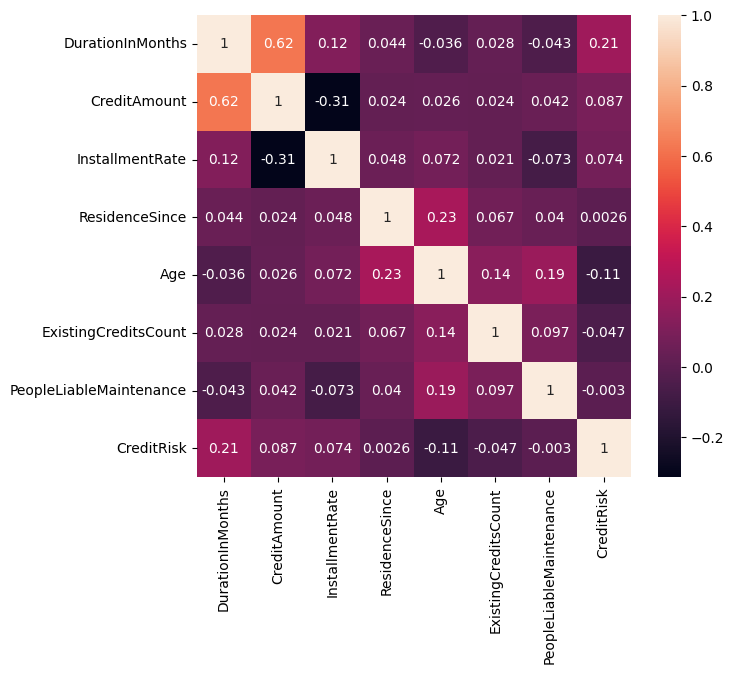

In [11]:
numerical_features = dataset_df.select_dtypes(include=["int64", "float64"])
numerical_features["CreditRisk"] = dataset_df["CreditRiskClass"].replace(to_replace={"Good": 0, "Bad": 1})

plt.figure(figsize=(7, 6))
sns.heatmap(data=numerical_features.corr(method='spearman'), annot=True)

In [12]:
numerical_features = dataset_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

dataset_df['CreditRiskClass'] = dataset_df['CreditRiskClass'].astype('category')


categories = dataset_df["CreditRiskClass"].unique()
category_1, category_2 = categories[0], categories[1]


significant_numerical_features = []

for feature in numerical_features:
    if pd.api.types.is_numeric_dtype(dataset_df[feature]):
        group1 = dataset_df[dataset_df["CreditRiskClass"] == category_1][feature].dropna()
        group2 = dataset_df[dataset_df["CreditRiskClass"] == category_2][feature].dropna()

        t_stat, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')

        print(f"\nT-test for {feature} vs CreditRiskClass")
        print(f"T-statistic: {t_stat}, P-value: {p_value}")

        if p_value < 0.05:
            print(f"The relationship between {feature} and CreditRiskClass is statistically significant.")
            significant_numerical_features.append(feature)
        else:
            print(f"The relationship between {feature} and CreditRiskClass is not statistically significant.")

print("\nStatistically significant numerical features:")
print(significant_numerical_features)



T-test for DurationInMonths vs CreditRiskClass
T-statistic: -6.9522507242467215, P-value: 6.4880498771843485e-12
The relationship between DurationInMonths and CreditRiskClass is statistically significant.

T-test for CreditAmount vs CreditRiskClass
T-statistic: -4.947965832165981, P-value: 8.797572373528893e-07
The relationship between CreditAmount and CreditRiskClass is statistically significant.

T-test for InstallmentRate vs CreditRiskClass
T-statistic: -2.2933418998928663, P-value: 0.022035486306949584
The relationship between InstallmentRate and CreditRiskClass is statistically significant.

T-test for ResidenceSince vs CreditRiskClass
T-statistic: -0.09373633429379342, P-value: 0.9253374212980939
The relationship between ResidenceSince and CreditRiskClass is not statistically significant.

T-test for Age vs CreditRiskClass
T-statistic: 2.890846677564194, P-value: 0.003925339398276282
The relationship between Age and CreditRiskClass is statistically significant.

T-test for Exist

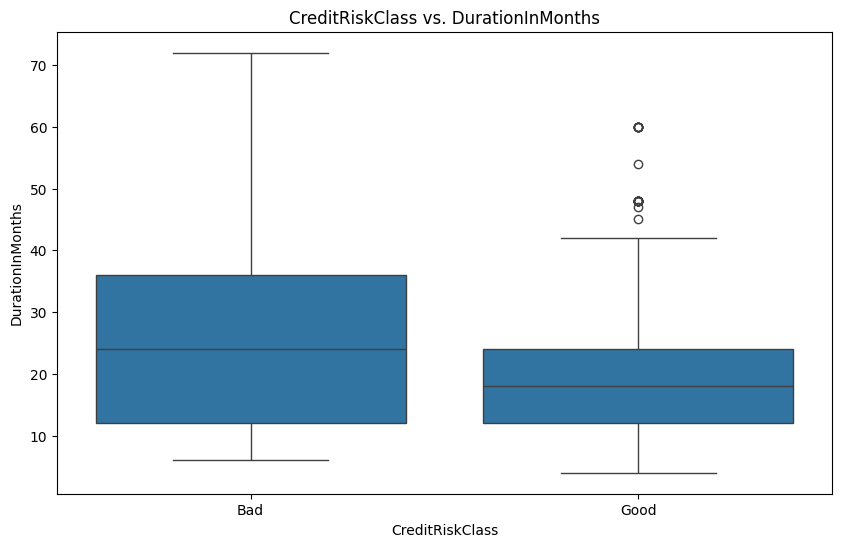

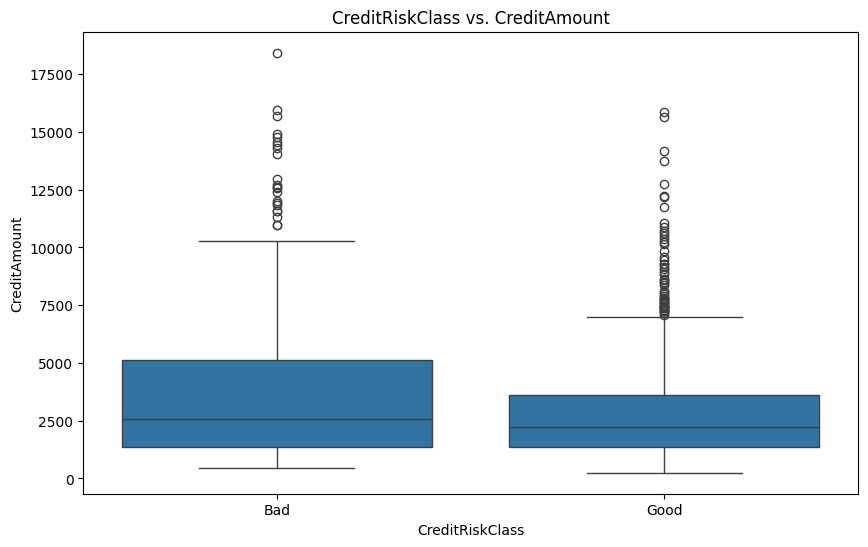

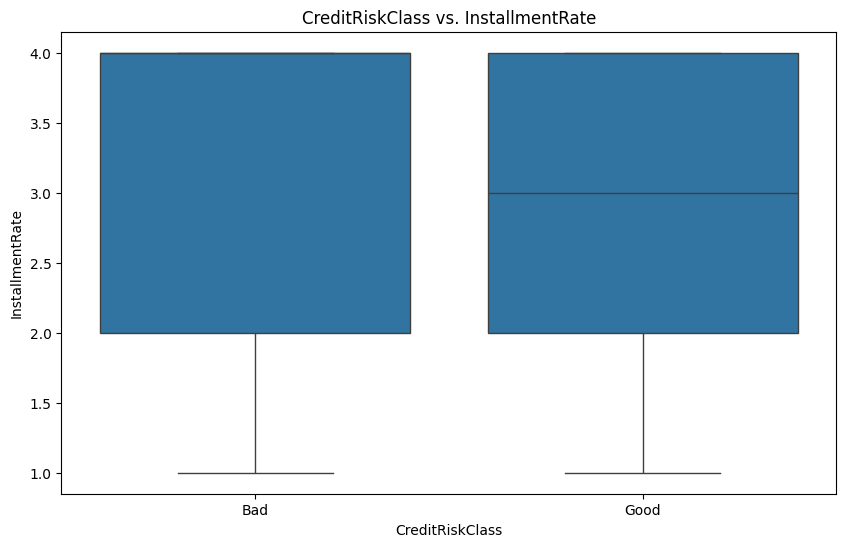

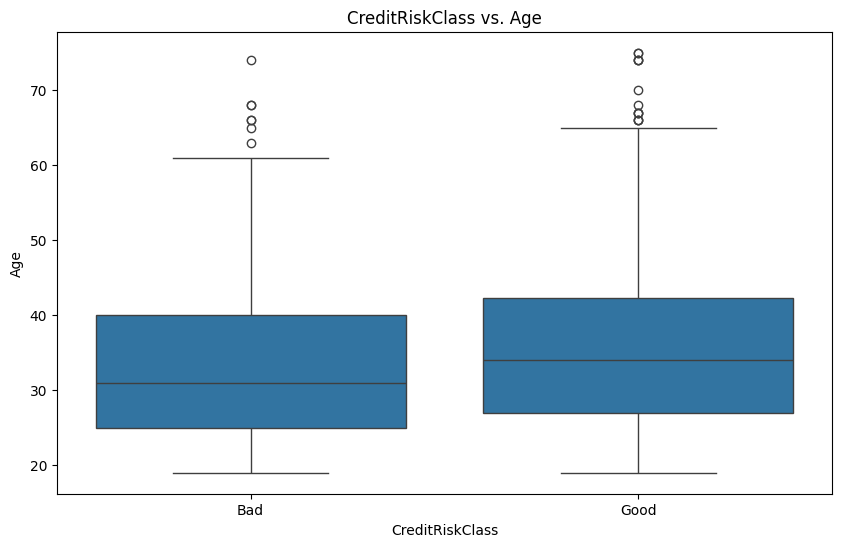

In [13]:
# Plotting CreditRiskClass against significant numerical features
for feature in significant_numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='CreditRiskClass', y=feature, data=dataset_df)
    plt.title(f'CreditRiskClass vs. {feature}')
    plt.show()


In [14]:
categorical_features = dataset_df.select_dtypes(include=['object']).columns
categorical_features = [feature for feature in categorical_features if feature != 'CreditRiskClass']

significant_categorical_features = []

for feature in categorical_features:
    contingency_table = pd.crosstab(dataset_df[feature], dataset_df['CreditRiskClass'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

    print(f"\nChi-Square Test for {feature} vs CreditRiskClass:")
    print(f"H0: There is no association between {feature} and CreditRiskClass.")
    print(f"Ha: There is an association between {feature} and CreditRiskClass.")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")

    if round(p,6) < 0.05:
        significant_categorical_features.append(feature)
        print(f"Conclusion: Reject the null hypothesis. The relationship between {feature} and CreditRiskClass is statistically significant.")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis. The relationship between {feature} and CreditRiskClass is not statistically significant.")

print("\nStatistically significant categorical features:")
print(significant_categorical_features)



Chi-Square Test for CheckingAccountStatus vs CreditRiskClass:
H0: There is no association between CheckingAccountStatus and CreditRiskClass.
Ha: There is an association between CheckingAccountStatus and CreditRiskClass.
Chi2 Statistic: 123.7209435162656
P-Value: 1.2189020722893755e-26
Degrees of Freedom: 3
Conclusion: Reject the null hypothesis. The relationship between CheckingAccountStatus and CreditRiskClass is statistically significant.

Chi-Square Test for CreditHistory vs CreditRiskClass:
H0: There is no association between CreditHistory and CreditRiskClass.
Ha: There is an association between CreditHistory and CreditRiskClass.
Chi2 Statistic: 61.691396964595505
P-Value: 1.2791872956750962e-12
Degrees of Freedom: 4
Conclusion: Reject the null hypothesis. The relationship between CreditHistory and CreditRiskClass is statistically significant.

Chi-Square Test for Purpose vs CreditRiskClass:
H0: There is no association between Purpose and CreditRiskClass.
Ha: There is an associati

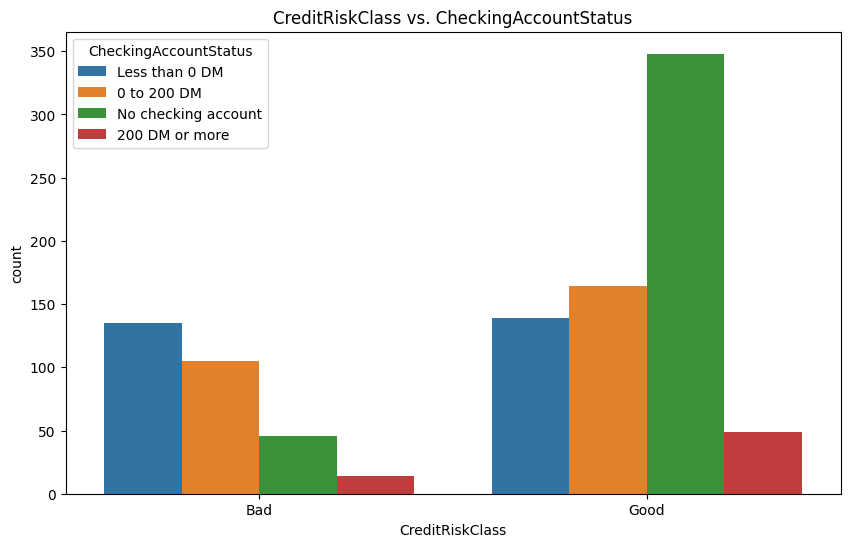

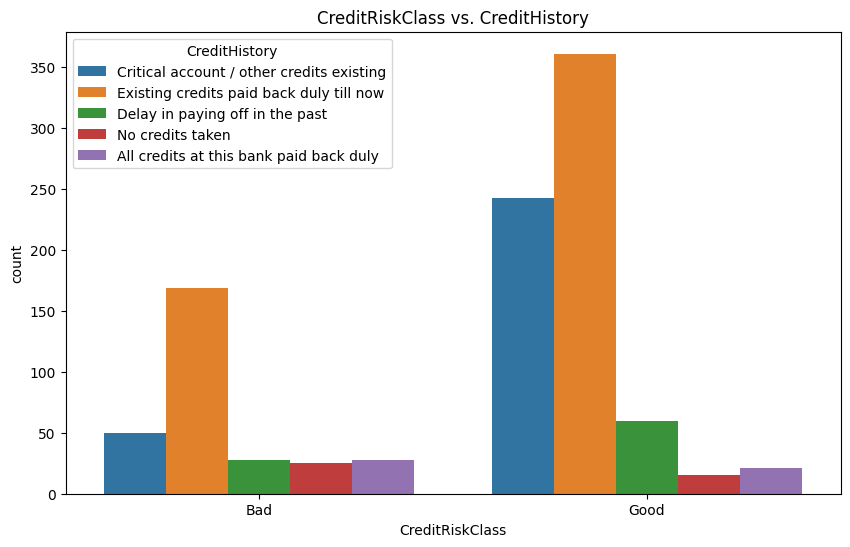

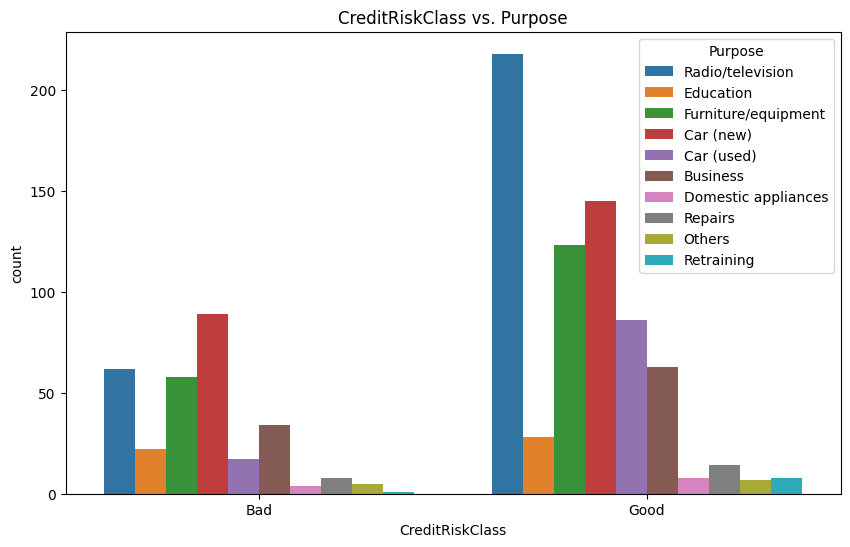

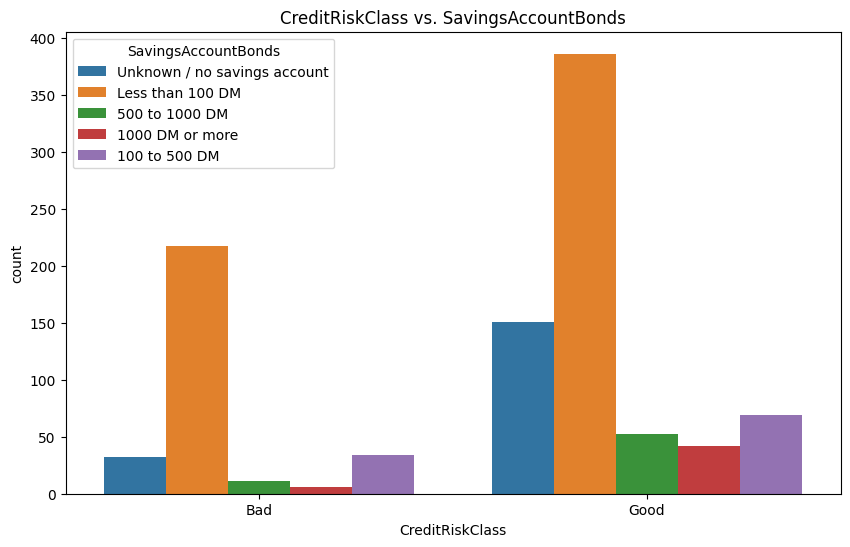

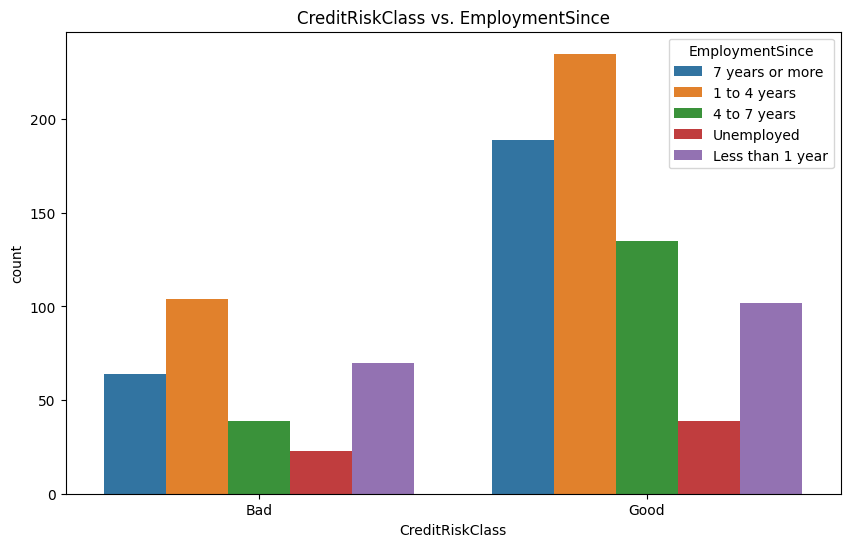

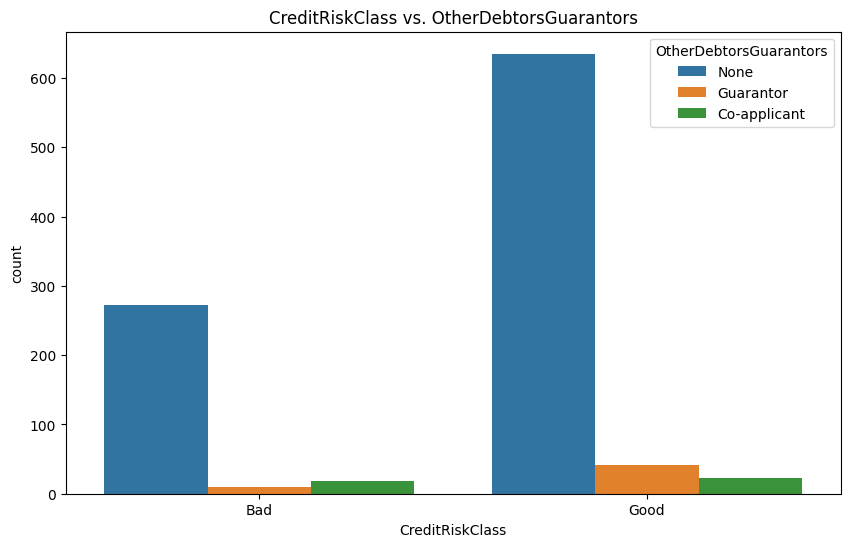

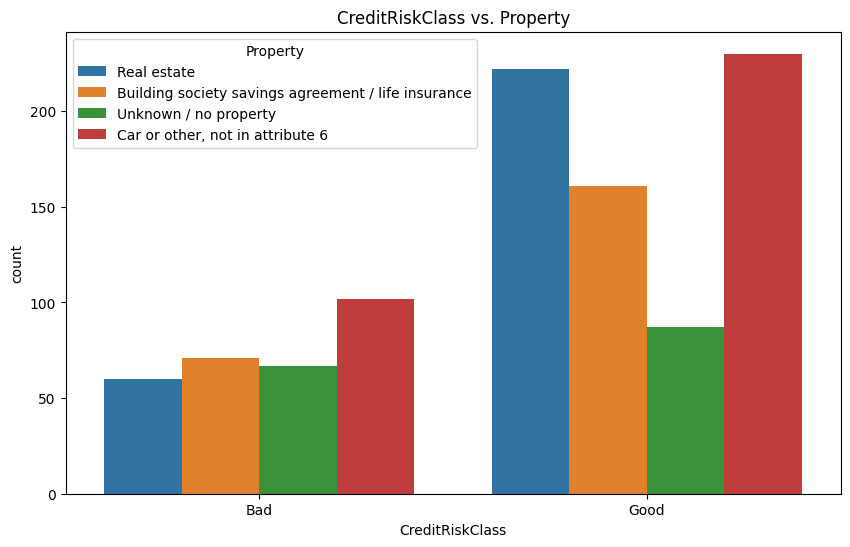

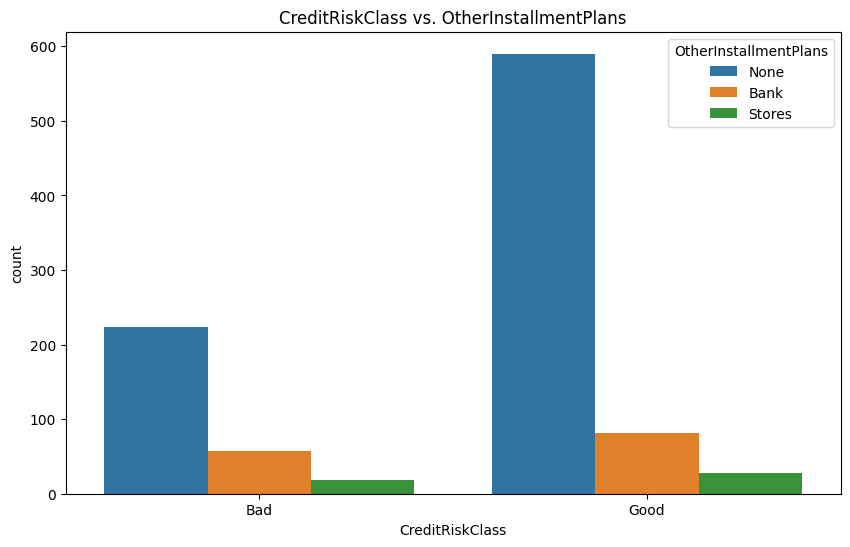

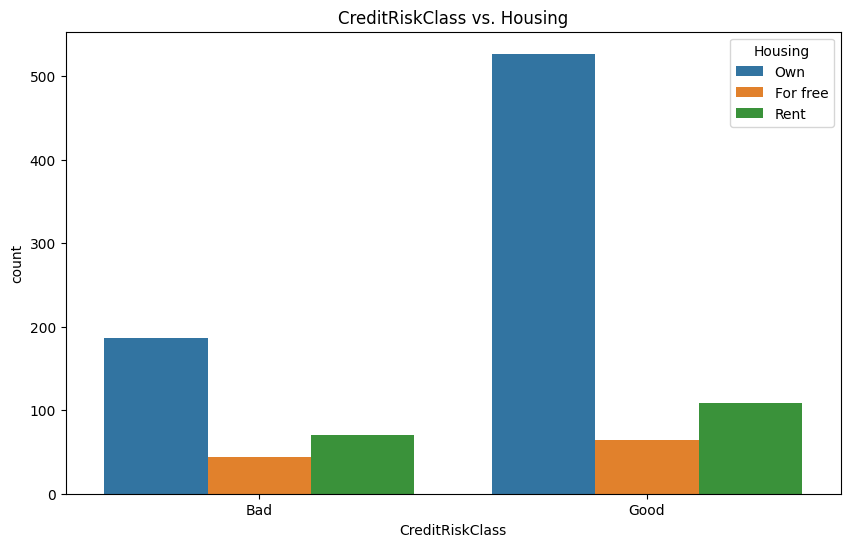

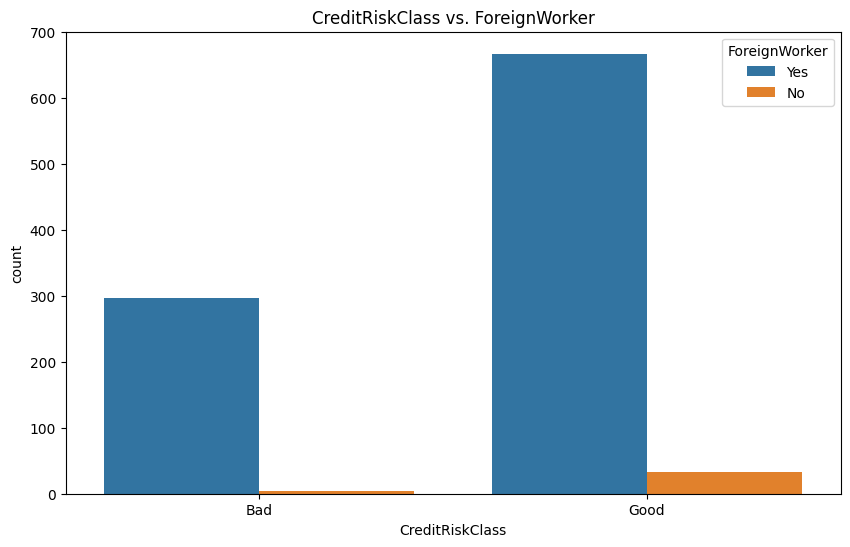

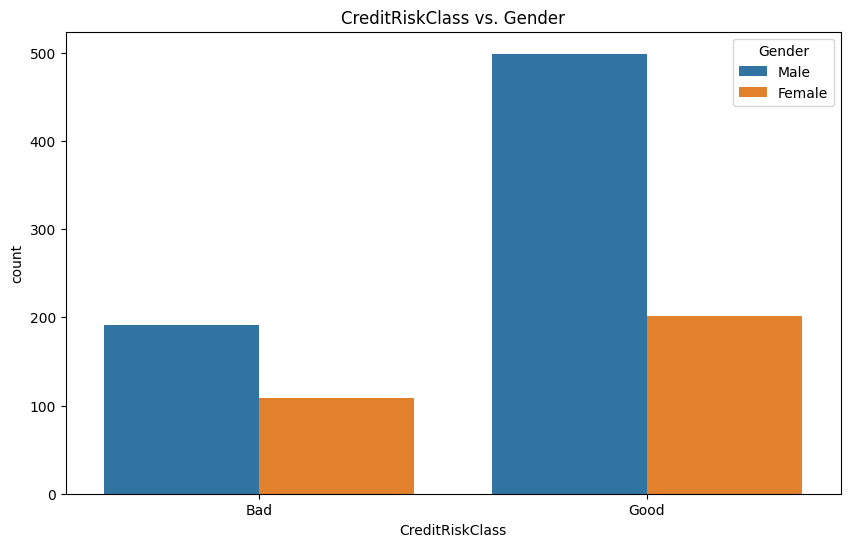

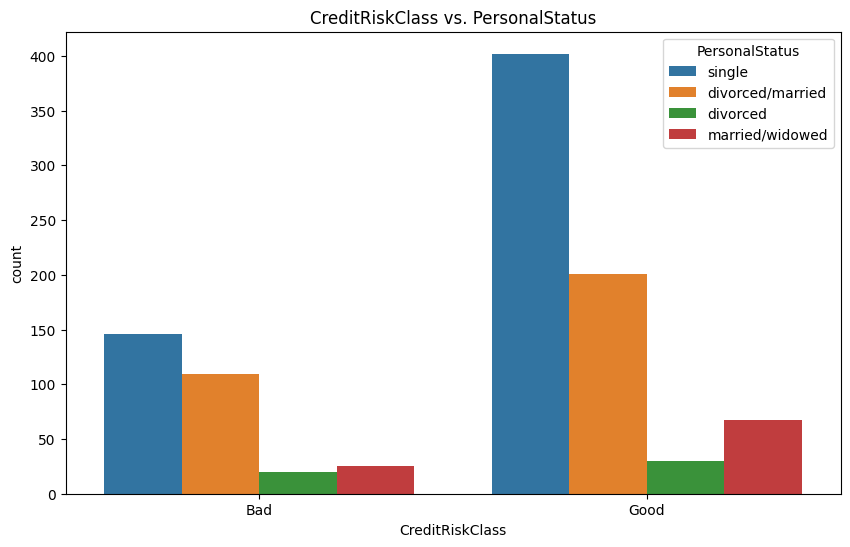

In [15]:
# Plotting CreditRiskClass against significant categorical features
for feature in significant_categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='CreditRiskClass', hue=feature, data=dataset_df)
    plt.title(f'CreditRiskClass vs. {feature}')
    plt.show()


Detecting Rare Categories

In [16]:
detect_rare_categories(dataset_df, 5)


 Categories in Feature CreditHistory below threshold freq: ['All credits at this bank paid back duly', 'No credits taken']
Relative Frequency: 
CreditHistory
Existing credits paid back duly till now     53.0
Critical account / other credits existing    29.3
Delay in paying off in the past               8.8
All credits at this bank paid back duly       4.9
No credits taken                              4.0
Name: proportion, dtype: float64

 Categories in Feature Purpose below threshold freq: ['Repairs', 'Domestic appliances', 'Others', 'Retraining']
Relative Frequency: 
Purpose
Radio/television       28.0
Car (new)              23.4
Furniture/equipment    18.1
Car (used)             10.3
Business                9.7
Education               5.0
Repairs                 2.2
Domestic appliances     1.2
Others                  1.2
Retraining              0.9
Name: proportion, dtype: float64

 Categories in Feature SavingsAccountBonds below threshold freq: ['1000 DM or more']
Relative Frequenc

Merging Rare Categories

In [17]:
dataset_df = merge_categories(dataset_df, feature="CreditHistory",
                 categories_to_merge=["All credits at this bank paid back duly", "No credits taken"],
                 merged_category_name="No credits taken or all credits paid back duly")

dataset_df = merge_categories(dataset_df, feature="Purpose",
                 categories_to_merge=["Retraining", "Domestic appliances", "Repairs", "Education"],
                 merged_category_name="Others")

dataset_df = merge_categories(dataset_df, feature="SavingsAccountBonds",
                              categories_to_merge=["500 to 1000 DM", "1000 DM or more"],
                              merged_category_name="500 DM or more")

dataset_df = merge_categories(dataset_df, feature="OtherDebtorsGuarantors",
                 categories_to_merge=["Guarantor", "Co-applicant"],
                 merged_category_name="Yes")
dataset_df["OtherDebtorsGuarantors"] = dataset_df["OtherDebtorsGuarantors"].replace("None", "No")

dataset_df = merge_categories(dataset_df, feature="OtherInstallmentPlans",
                 categories_to_merge=["Bank", "Stores"],
                 merged_category_name="Yes")
dataset_df["OtherInstallmentPlans"] = dataset_df["OtherInstallmentPlans"].replace("None", "No")

dataset_df = merge_categories(dataset_df, feature="Job",
                 categories_to_merge=["Unskilled - resident", "Unemployed / unskilled - non-resident"],
                 merged_category_name="Unemployed/Unskilled")
dataset_df["OtherInstallmentPlans"] = dataset_df["OtherInstallmentPlans"].replace("None", "No")

Removing Outliers

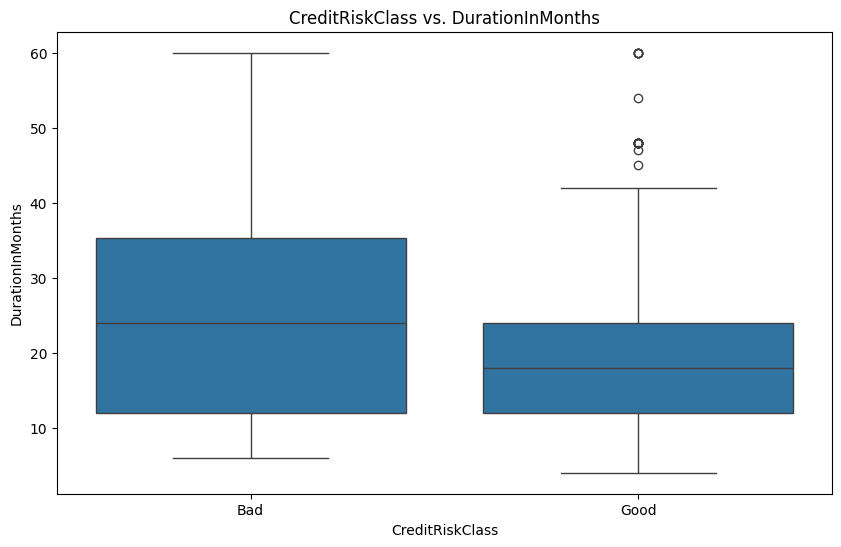

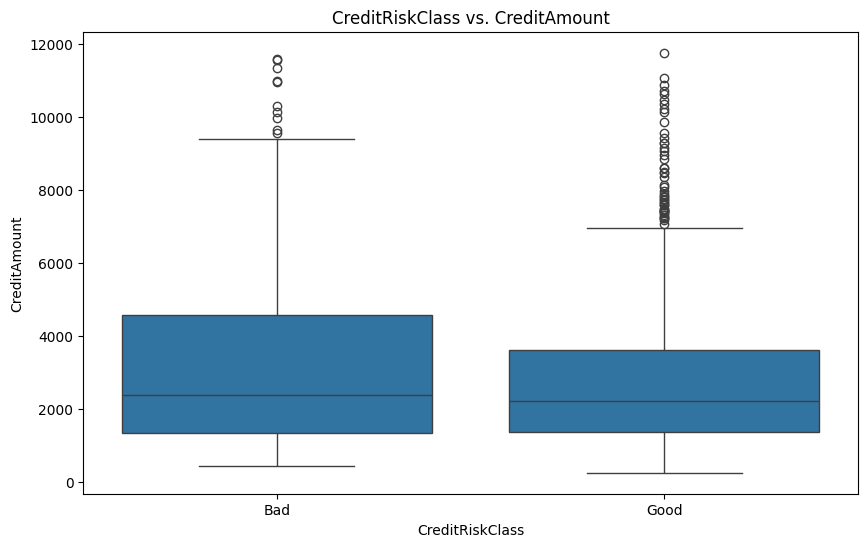

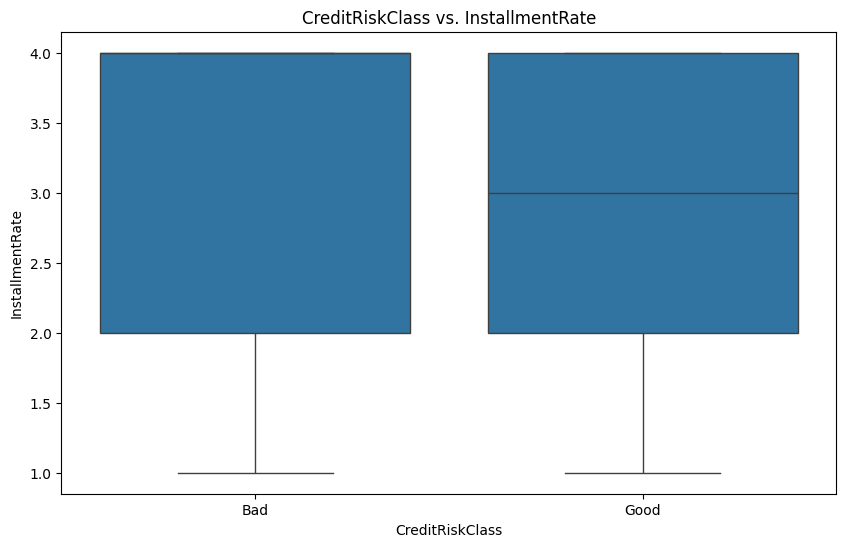

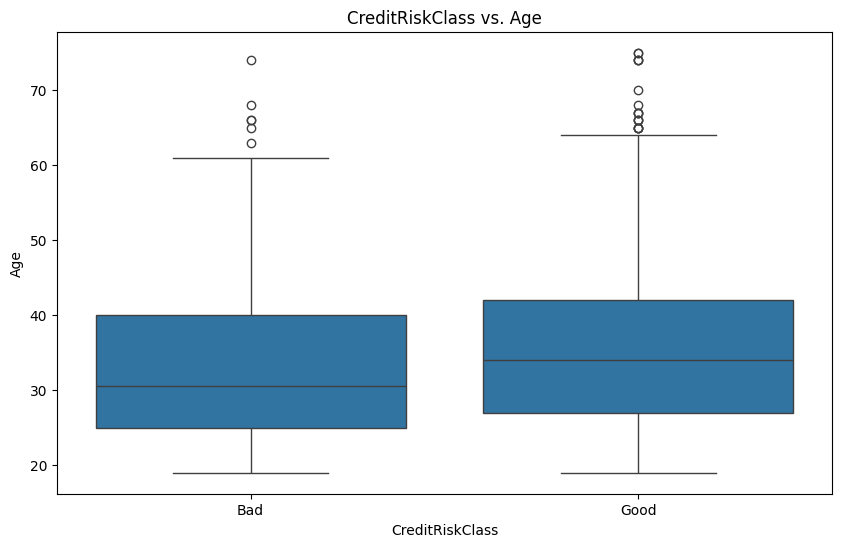

In [18]:
for col in significant_numerical_features:
        Q1 = dataset_df[col].quantile(0.25)
        Q3 = dataset_df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 3 * IQR
        dataset_df = dataset_df[dataset_df[col] <= upper_bound]

# Plotting CreditRiskClass against numerical features
for feature in significant_numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='CreditRiskClass', y=feature, data=dataset_df)
    plt.title(f'CreditRiskClass vs. {feature}')
    plt.show()

**Hypothesis Tests**


Testing if the mean credit amount differs between good and bad credit risk

H0: The mean credit amount is the same for good and bad credit risk

H1: The mean credit amount is different for good and bad credit risk

In [19]:
good_credit = dataset_df[dataset_df['CreditRiskClass'] == 'Good']['CreditAmount']
bad_credit = dataset_df[dataset_df['CreditRiskClass'] == 'Bad']['CreditAmount']


t_stat, p_val = stats.ttest_ind(good_credit, bad_credit)


print(f"T-statistic: {t_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Reject the null hypothesis: There is a significant difference in credit amounts.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in credit amounts.")


T-statistic: -2.8249072456530655, P-value: 0.004826109711080185
Reject the null hypothesis: There is a significant difference in credit amounts.


Testing the association between two categorical features.

H0: The two categorical features are independent.

H1: The two categorical features are not independent.



In [20]:
contingency_table = pd.crosstab(dataset_df['CheckingAccountStatus'], dataset_df['CreditRiskClass'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, P-value: {p_val}")
if p_val < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant association between CheckingAccountStatus and CreditRiskClass.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant association between CheckingAccountStatus and CreditRiskClass.")



Chi2: 117.93576243443869, P-value: 2.1477025557279006e-25
Conclusion: Reject the null hypothesis. There is a significant association between CheckingAccountStatus and CreditRiskClass.


Testing if there is a significant difference in credit amounts across different CheckingAccountStatus groups.

H0: The mean of the feature is the same for both groups.

H1: The mean of the feature is different for both groups.



In [21]:
groups = [group['CreditAmount'].values for name, group in dataset_df.groupby('CheckingAccountStatus')]
f_stat, p_val = stats.f_oneway(*groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant difference in credit amounts across different CheckingAccountStatus groups.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant difference in credit amounts across different CheckingAccountStatus groups.")


F-statistic: 3.5249131367487974, P-value: 0.0146058162187332
Conclusion: Reject the null hypothesis. There is a significant difference in credit amounts across different CheckingAccountStatus groups.


Testing the means of a numeric feature across multiple groups.

H0: The means of the feature are the same across all groups.

H1: At least one group mean is different.


In [22]:
groups = [group['CreditAmount'].values for name, group in dataset_df.groupby('CheckingAccountStatus')]
f_stat, p_val = stats.f_oneway(*groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")

F-statistic: 3.5249131367487974, P-value: 0.0146058162187332


Testing if there is a significant difference in the distribution of credit amounts between good and bad credit risk.

H0: The distributions of the feature are the same for both groups.

H1: The distributions of the feature are different for both groups.


In [23]:
ks_stat, p_val = stats.ks_2samp(good_credit, bad_credit)
print(f"KS-statistic: {ks_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant difference in the distribution of credit amounts between good and bad credit risk.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant difference in the distribution of credit amounts between good and bad credit risk.")


KS-statistic: 0.12488102913634828, P-value: 0.003445024632262349
Conclusion: Reject the null hypothesis. There is a significant difference in the distribution of credit amounts between good and bad credit risk.


Converting Categorical Data to Numerical

In [24]:
target_variable=["CreditRiskClass"]
significant_features=significant_categorical_features+significant_numerical_features
dataset_df=dataset_df[significant_features+target_variable]
for attr in significant_categorical_features:
    dataset_df = dataset_df.merge(pd.get_dummies(dataset_df[attr], prefix=attr), left_index=True, right_index=True)
    dataset_df.drop(attr,axis=1,inplace=True)
risk={"Good":1, "Bad":0}
dataset_df["CreditRiskClass"]=dataset_df["CreditRiskClass"].map(risk)
dataset_df.head()

,DurationInMonths,CreditAmount,InstallmentRate,Age,CreditRiskClass,CheckingAccountStatus_0 to 200 DM,CheckingAccountStatus_200 DM or more,CheckingAccountStatus_Less than 0 DM,CheckingAccountStatus_No checking account,CreditHistory_Critical account / other credits existing,...,Housing_Own,Housing_Rent,ForeignWorker_No,ForeignWorker_Yes,Gender_Female,Gender_Male,PersonalStatus_divorced,PersonalStatus_divorced/married,PersonalStatus_married/widowed,PersonalStatus_single
0,6,1169,4,67,1,False,False,True,False,True,...,True,False,False,True,False,True,False,False,False,True
1,48,5951,2,22,0,True,False,False,False,False,...,True,False,False,True,True,False,False,True,False,False
2,12,2096,2,49,1,False,False,False,True,True,...,True,False,False,True,False,True,False,False,False,True
3,42,7882,2,45,1,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,True
4,24,4870,3,53,0,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,True


Hypothesis Test for Model Prediction.

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

features = dataset_df.drop(columns=['CreditRiskClass'])
target = dataset_df['CreditRiskClass']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
svm_model = SVC()
gb_model = GradientBoostingClassifier()


dt_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)
svm_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)


dt_pred = dt_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)
svm_pred = svm_model.predict(X_test_scaled)
gb_pred = gb_model.predict(X_test_scaled)


dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)
gb_acc = accuracy_score(y_test, gb_pred)


print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}")


Decision Tree Accuracy: 0.7133
Random Forest Accuracy: 0.7406
SVM Accuracy: 0.7338
Gradient Boosting Accuracy: 0.7543
